In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
# Gráficos
# ==============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
# Gráfico de distribución para cada variable numérica
import matplotlib.ticker as ticker
# ==============================================================================
# Identificador de tipos de Distribucion
# ==============================================================================
from fitter import Fitter, get_common_distributions
# ==============================================================================
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split
# ==============================================================================
url = "C:/Users/and14/Desktop/Proyectos/Programacion/Python/2022/Practica_20220831_ML/00_Data_Sets/SaratogaHouses.csv"

datos = pd.read_csv(url, sep=",")

# Se renombran las columnas para que sean más descriptivas
datos.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios", 
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]
#Limpiar datos
datos = datos.fillna(0)

# Se convierte la variable chimenea tipo string
# ==============================================================================
datos.chimenea = datos.chimenea.astype("str")

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    return(corr_mat)
    
corr_matrix = datos.select_dtypes(include=['float64', 'int']).corr(method='pearson')
dic_replace = {'2': "2_mas",
               '3': "2_mas",
               '4': "2_mas"}

datos['chimenea'] = datos['chimenea'] \
                     .map(dic_replace) \
                     .fillna(datos['chimenea'])

Primera Linea para llegar al final del Ejercicio

Evaluar la capacidad predictiva de un modelo consiste en comprobar cómo de próximas son sus predicciones a los verdaderos valores de la variable respuesta. Para poder cuantificarlo de forma correcta, se necesita disponer de un conjunto de observaciones, de las que se conozca la variable respuesta, pero que el modelo no haya "visto", es decir, que no hayan participado en su ajuste. Con esta finalidad, se dividen los datos disponibles en un conjunto de entrenamiento y un conjunto de test. El tamaño adecuado de las particiones depende en gran medida de la cantidad de datos disponibles y la seguridad que se necesite en la estimación del error, 80%-20% suele dar buenos resultados. El reparto debe hacerse de forma aleatoria o aleatoria-estratificada.

In [2]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('precio', axis = 'columns'),
                                        datos['precio'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [3]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count      1382.000000
mean     211436.516643
std       96846.639129
min       10300.000000
25%      145625.000000
50%      190000.000000
75%      255000.000000
max      775000.000000
Name: precio, dtype: float64


In [4]:
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de test
-----------------------
count       346.000000
mean     214084.395954
std      104689.155889
min        5000.000000
25%      139000.000000
50%      180750.000000
75%      271750.000000
max      670000.000000
Name: precio, dtype: float64


In [5]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

In [6]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [7]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   metros_totales               1382 non-null   float64
 1   antiguedad                   1382 non-null   float64
 2   precio_terreno               1382 non-null   float64
 3   metros_habitables            1382 non-null   float64
 4   universitarios               1382 non-null   float64
 5   dormitorios                  1382 non-null   float64
 6   banyos                       1382 non-null   float64
 7   habitaciones                 1382 non-null   float64
 8   chimenea_0                   1382 non-null   float64
 9   chimenea_1                   1382 non-null   float64
 10  chimenea_2_mas               1382 non-null   float64
 11  calefaccion_electric         1382 non-null   float64
 12  calefaccion_hot air          1382 non-null   float64
 13  calefaccion_hot wa

c:\Users\and14\Desktop\Proyectos\Programacion\Python\2022\Practica_20220831_ML\01_Excercises_Jupyter\Intermendio\envDS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


ColumnTransformer aplica las operaciones de forma paralela, no de forma secuencial, esto significa que no permite aplicar más de una transformación a una misma columna. En el caso de que sea necesario hacerlo, hay que recurrir a los pipeline, que también agrupan operaciones pero las ejecutan de forma secuencial, de forma que la salida de una operación es la entrada de la siguiente. Si se quieren aplicar varias transformaciones de preprocesado sobre una misma columna, es necesario agruparlas primero en un pipeline

En el siguiente ejemplo se combinan las transormaciones:

Columnas numéricas: se imputan los valores ausentes con la mediana y a continuación se estandarizan.

Columnas categóricas (cualitativas): se imputan los valores ausentes con el valor más frecuente y a continuación se aplica one hot encoding.

In [8]:
# Selección de las variables por típo
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [9]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [15]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================

encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names_out(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382 entries, 0 to 1381
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   metros_totales               1382 non-null   float64
 1   antiguedad                   1382 non-null   float64
 2   precio_terreno               1382 non-null   float64
 3   metros_habitables            1382 non-null   float64
 4   universitarios               1382 non-null   float64
 5   dormitorios                  1382 non-null   float64
 6   banyos                       1382 non-null   float64
 7   habitaciones                 1382 non-null   float64
 8   chimenea_0                   1382 non-null   float64
 9   chimenea_1                   1382 non-null   float64
 10  chimenea_2_mas               1382 non-null   float64
 11  calefaccion_electric         1382 non-null   float64
 12  calefaccion_hot air          1382 non-null   float64
 13  calefaccion_hot wa

In [16]:
from sklearn import set_config
set_config(display='diagram')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['metros_totales', 'antiguedad',
                                  'precio_terreno', 'metros_habitables',
                                  'universitarios', 'dormitorios', 'banyos',
                                  'habitaciones']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['chimenea', 'calefaccion',
                                  'consumo_calefacion', 'desague',
                                  'vistas_lago', 'nueva_construccion',
                                  'aire_acondicionado'])])

In [17]:
set_config(display='text')

CREAR UN MODELO 

Entrenamiento

In [30]:
from sklearn.linear_model import Ridge

# Preprocedado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Pipeline
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = pipe.fit(X=X_train, y=y_train)

Validacion

In [31]:
# Validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-53936.72317457 -53076.62173058 -62746.09867095 -65963.27829356
 -48929.41263965]
Média métricas de validación cruzada: -56930.42690186192


In [32]:
# Validación cruzada repetida
# ==============================================================================
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv
             )

print(f"Métricas de validación cruzada: {cv_scores}")
print("")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas de validación cruzada: [-66487.8573032  -56333.73805693 -48992.73773098 -55030.00545855
 -58790.35424631 -62651.83552315 -55779.48452928 -61820.51578247
 -57243.2703664  -48910.63164697 -50033.29362635 -51586.76156014
 -62478.20830622 -65111.74567594 -54901.02012847 -64220.52636654
 -53694.95684321 -64691.096378   -51242.30746142 -52330.9686889
 -56777.09824695 -58644.53372882 -55573.23323551 -64350.19106034
 -50578.09776655]

Média métricas de validación cruzada: -57130.17878870382


In [33]:
# Validación cruzada repetida con múltiples métricas
# ==============================================================================
from sklearn.model_selection import cross_validate

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.011004,0.004543,0.632360,0.679758,-64605.481467,-51789.256510
1,0.010363,0.004103,0.718709,0.636812,-48322.355302,-59983.016685
2,0.006795,0.004000,0.595876,0.689939,-58434.830876,-55213.676870
3,0.007008,0.006405,0.672968,0.655316,-58179.235310,-55331.536238
4,0.006001,0.004245,0.615521,0.683390,-60148.301479,-54366.377431
5,0.004998,0.004524,0.650828,0.664771,-53812.641908,-57561.140576
6,0.006000,0.003647,0.698179,0.647441,-49813.157641,-59221.407345
7,0.006002,0.003000,0.646554,0.673017,-61749.464910,-53221.289450
8,0.007455,0.003990,0.615152,0.682999,-59192.937599,-54895.160688
9,0.008383,0.004142,0.645681,0.670427,-61061.383968,-53843.525637


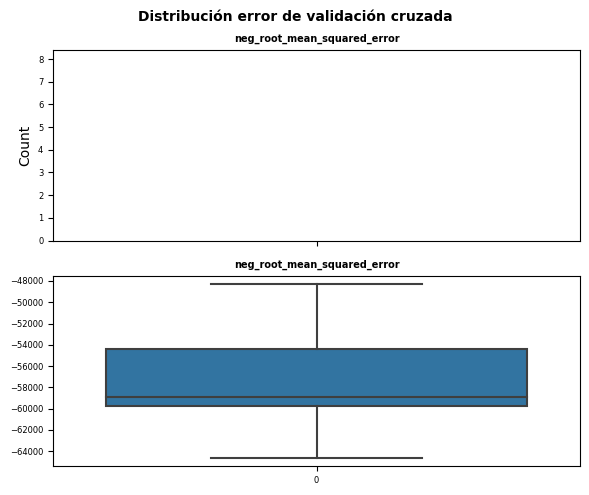

In [34]:
# Distribución del error de validación cruzada
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)

sns.histplot(
    data    = cv_scores['test_neg_root_mean_squared_error'],
    stat    = "count",
    kde     = True,
    line_kws= {'linewidth': 2},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
)

axes[0].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[0].tick_params(labelsize = 6)
axes[0].set_xlabel("")
    
sns.boxplot(
    cv_scores['test_neg_root_mean_squared_error'],
    ax      = axes[1]
)
axes[1].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[1].tick_params(labelsize = 6)
axes[1].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución error de validación cruzada', fontsize = 10,
             fontweight = "bold");

C:\Users\and14\AppData\Local\Temp\ipykernel_13368\4070543022.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
c:\Users\and14\Desktop\Proyectos\Programacion\Python\2022\Practica_20220831_ML\01_Excercises_Jupyter\Intermendio\envDS\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


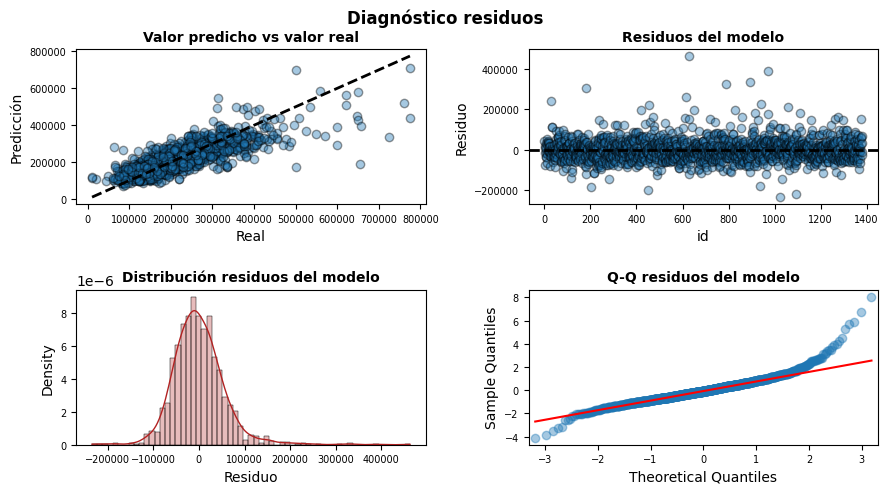

In [35]:
# Diagnóstico errores (residuos) de las predicciones de validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
import statsmodels.api as sm

# Validación cruzada
# ==============================================================================
cv = KFold(n_splits=5, random_state=123, shuffle=True)
cv_prediccones = cross_val_predict(
                    estimator = pipe,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv
                  )

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))

axes[0, 0].scatter(y_train, cv_prediccones, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), y_train - cv_prediccones,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_train - cv_prediccones,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_train - cv_prediccones,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");